# Test the performance with synthetic images

In [1]:
import time
import numpy as np
import cv2
import matplotlib.pyplot as plt

from fringes import fringe_wrapper
from phase import phase_wrapper
from config import config

rmse = lambda diff: np.sqrt(np.nanmean(diff ** 2))
dist = lambda points: np.sqrt(np.sum(points**2, axis=-1))

ply_header = '''ply
format ascii 1.0
element vertex %(vert_num)d
property float x
property float y
property float z
end_header
'''
def write_ply(fn, verts):
    verts = verts[:,20:-20,:]
    verts = verts.reshape(-1, 3)
    with open(fn, 'wb') as f:
        f.write((ply_header % dict(vert_num=len(verts))).encode('utf-8'))
        np.savetxt(f, verts, fmt='%f %f %f')
        
def recons3d(disparity):
    h, w = disparity.shape[0:2]
    f = 5.0*w                          # artificial focal length                      
    Q = np.float32([[5, 0, 0, -0.5*w],
                    [0,-5, 0,  0.5*h], # turn points 180 deg around x-axis,
                    [0, 0, 0,     -f], # so that y-axis looks up
                    [0, 0, 1,      0]])
    points = cv2.reprojectImageTo3D(disparity.astype(np.float32), Q)
    return points

methods = ["PE", "MPE", "LLS", "CFPE"]
linetypes = [":>", "--s", "-.<", "-o"]

In [2]:
# config
cfg = config()
cfg.debug = False
cfg.pattern_size = (512, 128)
# cfg.pattern_size = (1980, 30)

# cfg.Tp = [14, 15, 16]   # Combined period 1680.0   *** for paper ***
cfg.Tp = [33, 36, 39]   # Combined period 2574  *** for paper ***

# Note that, we must update Tc and alpha for correct phase extraction
cfg.Tc = cfg.Tp # Tc is for camera recordings
cfg.alpha = [1, cfg.Tp[0]/cfg.Tp[1], cfg.Tp[0]/cfg.Tp[2]]

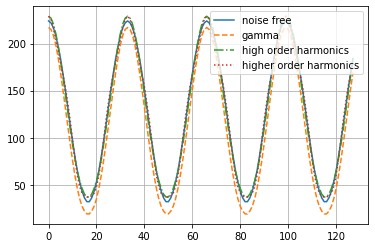

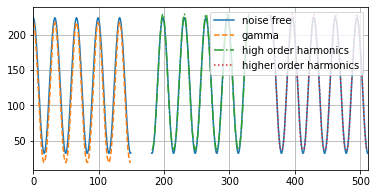

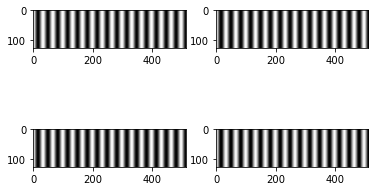

In [3]:
# Show 4 test images 
# - gamma free, gamma distorsion
# - high-order harmonics, higher-order harmonics
fringe_images = []
cfg.gamma = 1.0
fringe_images.append(fringe_wrapper(cfg, "gamma").generate_all())

cfg.gamma = 1.25
fringe_images.append(fringe_wrapper(cfg, "gamma").generate_all())

cfg.C, cfg.D = 5, 0
fringe_images.append(fringe_wrapper(cfg, "harmonic").generate_all())

cfg.C, cfg.D = 0, 5
fringe_images.append(fringe_wrapper(cfg, "harmonic").generate_all())

#
temptypes = ["-", "--", "-.", ":"]
plt.figure()
for k, case_list in enumerate(fringe_images):
    plt.plot(case_list[0][0][0,:128], temptypes[k])
plt.legend(["noise free","gamma","high order harmonics", "higher order harmonics"], loc=1)
plt.grid("on")
plt.savefig("./data/results/syn_image_curve.pdf")

plt.figure(figsize=(6,3))
curve = fringe_images[0][0][0][0,:]
curve[150:181], curve[331:362] = np.nan, np.nan
plt.plot(curve, temptypes[0])
curve = fringe_images[1][0][0][0,:]
curve[150:] = np.nan
plt.plot(curve, temptypes[1])
curve = fringe_images[2][0][0][0,:]
curve[:181], curve[331:] = np.nan, np.nan
plt.plot(curve, temptypes[2])
curve = fringe_images[3][0][0][0,:]
curve[:362] = np.nan
plt.plot(curve, temptypes[3])
plt.legend(["noise free","gamma","high order harmonics", "higher order harmonics"], loc=1)
plt.grid("on")
plt.xlim(0,512)
plt.savefig("./data/results/syn_image_curve.pdf")



plt.figure()
for k, case_list in enumerate(fringe_images):
    plt.subplot(2,2,k+1)
    plt.imshow(case_list[0][0], cmap="gray")

cv2.imwrite("./data/results/syn_image.png", fringe_images[0][0][0])
plt.show()

RMSE(phase):[0.056132962889457655, 0.03417626411300422, 0.0014490119963693087, 0.001989109517213267]
RMSE(point):[0.10811128, 0.06615588, 0.0027799157, 0.0036751877]


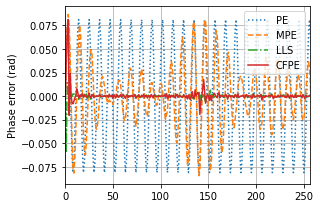

In [4]:
# A case study with gamma=1.4
def case_study(cfg, noise_model="gamma"):
    # generate the test images, ground truth of phase map and points
    fringe_generator = fringe_wrapper(cfg, noise_model)
    fringe_images = fringe_generator.generate_all()
    phase_truth = fringe_generator.generate_phase()
    point_truth = recons3d(phase_truth*0+88)

    # phase extraction and convert to 3d points
    phase_measures = [phase_wrapper(cfg, m).phase_extract(fringe_images)[0] for m in methods]
    disparitys = [(pm-phase_truth)*cfg.Tp[0]/(2*np.pi)+88 for pm in phase_measures]
    point_measures = [recons3d(disp) for disp in disparitys]

    # Performance evaluation
    rmse_phase = [rmse(p[:,20:-20]- phase_truth[:,20:-20]) for p in phase_measures]
    rmse_point = [rmse(dist(p[:,20:-20,:]- point_truth[:,20:-20,:])) for p in point_measures]
    return rmse_phase, rmse_point, phase_truth, point_truth, phase_measures, point_measures

cfg.pattern_size = (512, 30)
cfg.gamma=1.4
rmse_phase, rmse_point, phase_truth, point_truth, phase_measures, point_measures = case_study(cfg)
for k, p in enumerate(point_measures):
    write_ply(methods[k]+".ply", p)
    
print(f"RMSE(phase):{rmse_phase}")
print(f"RMSE(point):{rmse_point}")
# Visulization of error
plt.figure(figsize=(4.5,3))
for k, p in enumerate(phase_measures):
#     plt.plot(phase_truth[10,10:266]-p[10,10:266], linetypes[k][:-1], label=methods[k])
    plt.plot(phase_truth[10,:]-p[10,:], linetypes[k][:-1], label=methods[k])
#     plt.plot(phase_truth[10,650:675]-p[10,650:675], linetypes[k][:-1], label=methods[k])
plt.ylabel("Phase error (rad)")
plt.legend(loc=1)
plt.grid("on")
plt.tight_layout()
plt.xlim(0,256)
plt.savefig("./data/results/phase_error_location.pdf")
plt.show()

gamma:0.6
gamma:0.7
gamma:0.8
gamma:0.9
gamma:1.0
gamma:1.1
gamma:1.2
gamma:1.3
gamma:1.4


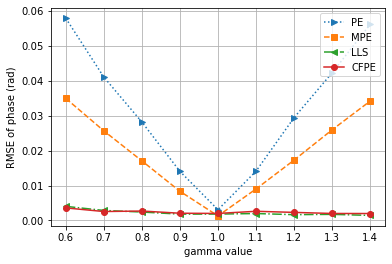

In [5]:
# The performance curve with different gamma value
cfg.pattern_size = (512, 30)
gammas = np.linspace(0.6, 1.4, 9)
phase_error, point_error = [], []
for gamma in gammas:
    print(f"gamma:{gamma:.1f}")
    cfg.gamma = gamma
    rmse_phase, rmse_point, phase_truth, point_truth, phase_measures, point_measures = case_study(cfg, "gamma")
    phase_error.append(rmse_phase)
    point_error.append(rmse_point)

phase_error = np.array(phase_error)
point_error = np.array(point_error)

fig = plt.figure()
for k, method in enumerate(methods):
    plt.plot(gammas, phase_error[:,k], linetypes[k], label=method)
plt.legend(loc=1)
plt.ylabel("RMSE of phase (rad)")
plt.xlabel("gamma value")
plt.grid("on")
plt.savefig("./data/results/gamma_phase_error.pdf")    

# fig = plt.figure()
# for k, method in enumerate(methods):
#     plt.plot(gammas, point_error[:,k], linetypes[k], label=method)
# plt.legend(loc=1)
# plt.ylabel("RMSE of points (mm)")
# plt.xlabel("gamma value")
# plt.grid("on")
# plt.savefig("./data/results/gamma_point_error.pdf")    

C:-7.0
C:-6.0
C:-5.0
C:-4.0
C:-3.0
C:-2.0
C:-1.0
C:0.0
C:1.0
C:2.0
C:3.0
C:4.0
C:5.0
C:6.0
C:7.0


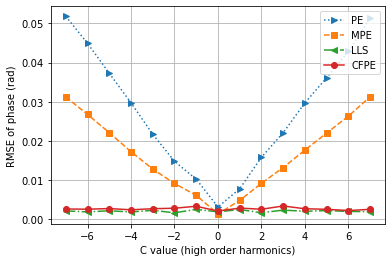

In [6]:
# The performance curve with different C value, the high order harmonics 
Cs = np.linspace(-7, 7, 15)
phase_error, point_error = [], []
for C in Cs:
    print(f"C:{C:.1f}")
    cfg.C, cfg.D = C, 0
    rmse_phase, rmse_point, phase_truth, point_truth, phase_measures, point_measures = case_study(cfg, "harmonic")
    phase_error.append(rmse_phase)
    point_error.append(rmse_point)

phase_error = np.array(phase_error)
point_error = np.array(point_error)

fig = plt.figure()
for k, method in enumerate(methods):
    plt.plot(Cs, phase_error[:,k], linetypes[k], label=method)
plt.legend(loc=1)
plt.ylabel("RMSE of phase (rad)")
plt.xlabel("C value (high order harmonics)")
plt.grid("on")
plt.savefig("./data/results/c_phase_error.pdf")    

# fig = plt.figure()
# for k, method in enumerate(methods):
#     plt.plot(Cs, point_error[:,k], linetypes[k], label=method)
# plt.legend(loc=1)
# plt.ylabel("RMSE of points (mm)")
# plt.xlabel("C value (high order harmonics)")
# plt.grid("on")
# plt.savefig("./data/results/c_point_error.pdf")  

D:-7.0
D:-6.0
D:-5.0
D:-4.0
D:-3.0
D:-2.0
D:-1.0
D:0.0
D:1.0
D:2.0
D:3.0
D:4.0
D:5.0
D:6.0
D:7.0


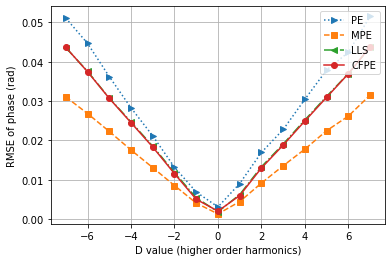

In [7]:
# The performance curve with different D value, the higher order harmonics 
Ds = np.linspace(-7, 7, 15)
phase_error, point_error = [], []
for D in Ds:
    print(f"D:{D:.1f}")
    cfg.C, cfg.D = 0, D
    rmse_phase, rmse_point, phase_truth, point_truth, phase_measures, point_measures = case_study(cfg, "harmonic")
    phase_error.append(rmse_phase)
    point_error.append(rmse_point)

phase_error, point_error = np.array(phase_error), np.array(point_error)

fig = plt.figure()
for k, method in enumerate(methods):
    plt.plot(Ds, phase_error[:,k], linetypes[k], label=method)
plt.legend(loc=1)
plt.ylabel("RMSE of phase (rad)")
plt.xlabel("D value (higher order harmonics)")
plt.grid("on")
plt.savefig("./data/results/d_phase_error.pdf")    

# fig = plt.figure()
# for k, method in enumerate(methods):
#     plt.plot(Ds, point_error[:,k], linetypes[k], label=method)
# plt.legend(loc=1)
# plt.ylabel("RMSE of points (mm)")
# plt.xlabel("D value (higher order harmonics)")
# plt.grid("on")
# plt.savefig("./data/results/d_point_error.pdf")  

In [8]:
# The time costs, it needs ~10 min to obtain the final results
cfg.C, cfg.D = 0, 0
sizes = [(256,256),(512,512),(1024,1024),(2048,2048)]
runs =10
# sizes = [(256,256),(512,512),(1024,50),(2048,50)]

def one_run(cfg, noise_model="gamma"):
    fringe_generator = fringe_wrapper(cfg, noise_model)
    fringe_images = fringe_generator.generate_all()
    phase_truth = fringe_generator.generate_phase()
    point_truth = recons3d(phase_truth*0+88)

    # phase extraction and execution time 
    cost = []
    for k, m in enumerate(methods):
        extractor = phase_wrapper(cfg, m)
        start = time.time()
        _,_ = extractor.phase_extract(fringe_images)
        end = time.time()
        cost.append(end-start)
    return cost

data = []
for sz in sizes:
    print(f"size", sz)
    cfg.pattern_size = sz
    costs = []
    for i in range(runs):
        cost = one_run(cfg)
        costs.append(cost)

    costs = np.array(costs)
    print(np.mean(costs, axis=0))
    print(np.std(costs, axis=0))
    data.append(np.mean(costs, axis=0))
data = np.array(data)

size (256, 256)


KeyboardInterrupt: 

In [ ]:
ind = np.arange(len(sizes))

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(ind - 0.3, data[:,0], width = 0.2)
ax.bar(ind - 0.1, data[:,1], width = 0.2)
ax.bar(ind + 0.1, data[:,2], width = 0.2)
ax.bar(ind + 0.3, data[:,3], width = 0.2)

ax.set_xticks(ind)
ax.set_xticklabels(["256","512","1024","2048"])
ax.legend(labels=methods)
plt.ylabel("Time (seconds)")
# ax.set_yscale('log')
plt.grid("on")
plt.savefig("./data/results/time_cost.pdf")
plt.show()